# Matter power spectrum $P(k,z)$ from theory (CAMB) to observations

## Import libraries and modules, check CAMB version

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt

# '"text.usetex": True' causes  runtime errors when plotting.
plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": "Computer Modern",
    "font.size": 22})


import numpy as np
from scipy import integrate as integrate
import math

from astropy.cosmology import Planck18 # Planck 2018 cosmology, see https://arxiv.org/abs/1807.06209
import astropy.units as au # Astrophysical units

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.4.0 installed at /home/carter/.venv.camb/lib/python3.10/site-packages/camb


In [3]:
#Define some useful constants
H0_inv = 2997.8 #h^{-1} Mpc

## Specify cosmology

### We can specify our own cosmology or read from an ini file, in this case we read cosmology the Planck 2018 base $\Lambda$CDM constraint

In [4]:
pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
print(pars)

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_both
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 1.3464234
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2700
 max_l_tensor = 600
 max_eta_k = 18000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0223828
 omch2 = 0.1201075
 omk = 0.0
 omnuh2 = 0.0006451439
 H0 = 67.32117
 TCMB = 2.7255
 YHe = 0.2454006
 num_nu_massless = 2.046
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = True
 nu_mass_degeneracies = [0.0]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_indeptilt
   ns = 0.9660499
   nrun = 0.0
   nrunrun = 0.0
 

### If you want to further adjust cosmological parameter(s), you can do so here

In [5]:
## Better to set values for all varying cosmological parameters in the same place
#H0=
#omch2=
#ombh2=
#omk=
#mnu=
#tau=
#As=
#ns=
#r=0.

## Set parameters control the homogeneous background universe
#pars.set_cosmology(H0=,ombh2=,omch2=,omk=,mnu=,tau=)

## Set parameters control the inhomogeneous universe, i.e. the primordial perturbations
#pars.InitPower.set_params(As=, ns=, r=)

## Check and understand CAMB theoretical prediction

### Set some parameter range

In [6]:
redshift_snaphots=[1.]
kmin=1e-4
kmax=2.0
nr_k_points=200
pars.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax)

surveyParams = {
    'dz' : 3,
    'z' : 2,
    'omSurvey' : 2*math.pi, #Survey area, sr
    'n_objects' : 1e-2
}
surveyParams['f_sky'] = surveyParams['omSurvey']/(4*math.pi)

### Compute theoretical prediction for $P(k,z)$ from CAMB

In [7]:
results = camb.get_results(pars) # invoke CAMB to solve the coupled Boltzmann equations for perturbations and get the results
# Note here that technically we output the nonlinear P(k), i.e. linear P(k) with corrections to account for nonlinear evolutions
kh, z, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = nr_k_points)

### Visualize results

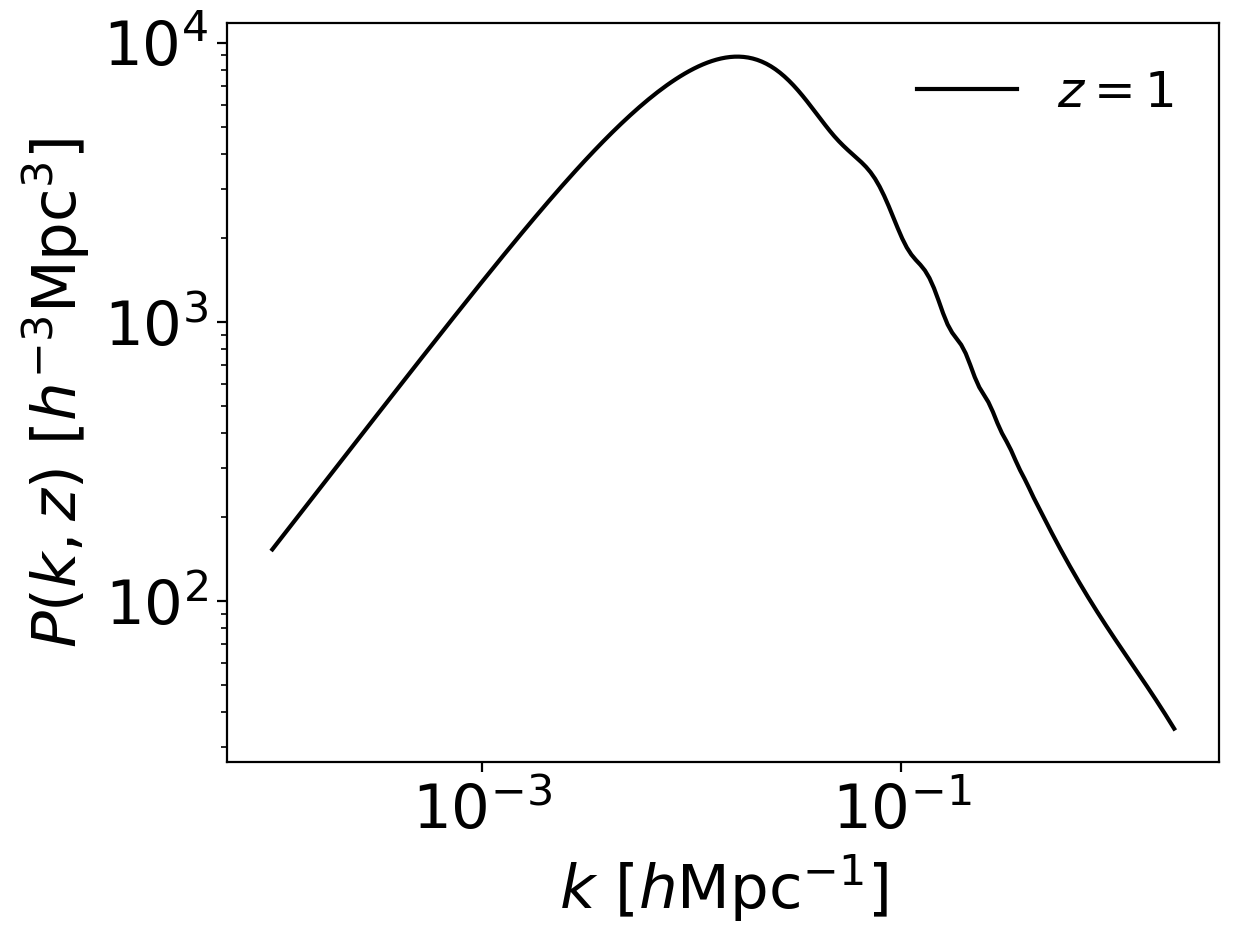

In [8]:
fig,ax=plt.subplots()
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    ax.loglog(kh, pk_nonlin[i,:], color='k', ls = line, label=r'$z=%d$'%redshift)
ax.set_xlabel(r'$k\,\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k,z)\,\,[h^{-3}\mathrm{Mpc}^3]$')
ax.legend(frameon=False,fontsize=18)
plt.show()

## Connection to observations - Cosmic variance and shot noise

### Cosmic variance

Within each range of Fourier mode (wavenumber) $k=|\vec{k}|$ , there is a finite number of Fourier modes $N_{\mathrm{modes}}(k)$. The precise numbers depend on the fundamental Fourier mode, the lowest mode probed by the survey $k_F=2\pi/L$, where $L$ denotes the side length of the box if you imagine encapsulating the survey into a cubic volume.

Therefore at each $k$, we effectively measure or estimate $\bar{P}(k)$ from $N_{\mathrm{modes}}(k)$ samples.

Here, we use the FKP error bars for a redshift survey given by Gibelyou, et al. ([arXiv:1007.0757](https://arxiv.org/abs/1007.0757)) as $$\sigma^2_P(k,z) = \frac{4\pi^2P(k,z)^2}{k^2dkdV_{\mathrm{eff}}},$$
with $dV_{\mathrm{eff}}(k,z) = \left[\frac{n(z)P(k,z)}{1+n(z)P(k,z)}\right]^2dV_\mathrm{survey}(z)$ and $dV_\mathrm{survey} = \Omega_\mathrm{survey}\frac{r(z)^2}{H(z)}dz.$

This formula for the variance appears to be derived from a similar formula in Feldman, et al. ([arXiv:astro-ph/9304022](https://arxiv.org/abs/astro-ph/9304022)),
$$ \frac{\sigma^2_P(k)}{P^2(k)} = \frac{(2\pi)^3\int d^3r\bar{n}^4w^4[1+1/\bar{n}P(k)^2]}{V_k[\int d^3r\bar{n}^2w^2]^2}$$
for the fractional variance of the power spectrum assuming Gaussian fluctuations in the square root of the true power spectrum plus shot noise ($F(\mathbf{k})$ in Feldman, et al.), and where $w(\mathbf{r}) = \frac{1}{1+\bar{n}(\mathbf{r})P(k)} under the assumption that our sampling of the density distribution is Poissonian.$ After some rewriting, we can see that the formula from Gibelyou, et al. becomes

$$\frac{\sigma_P^2(k,z)}{P^2(k,z)} = \frac{4\pi^2}{k^2dk}\cdot\left[1+\frac{1}{n(k,z)P(k,z)}\right]^2\cdot\frac{1}{dV_\mathrm{survey}},$$

which is roughly of the same form as the FKP formula if we take $V_k = k^2dk$ and squint a little bit. $\textcolor{red}{\text{[CM: how exactly is this formula from Dragan's paper derived from the FKP formula?]}}$

### Shot noise

When we measure $P(k)$ in simulations or observations, we use some discrete tracers to sample/represent the underlying continous matter density field $\delta_m(k)$. Due to the discrete nature, they introduce Poisson shot noise into the $\bar{P}(k)$ estimator:

$$\bar{P}(k)=P(k)+P_{\mathrm{shotnoise}}$$

where it is often *assumed* that $P_{\mathrm{shotnoise}}=\frac{1}{n_\mathrm{tracer}},$ with $n_{\mathrm{tracer}}$ being the tracer volume density.

### Putting things together, (CAMB) theoretical prediction with observational error bars

In [9]:
def get_closest_index(search_value, array):
    """Get the index of the closest value in the strictly increasing numpy array array to the value search_value.
    If two elements of the array are equally close to the search value, returns the earlier index."""
    if(array.size==1):
        return 0
    if not (np.all(array[1:]>array[:-1])):
        raise Exception("Array is not strictly increasing.")
    if(search_value<=array[0]):
        return 0
    if(search_value>=array[-1]):
        return array.size-1
    #search value now guaranteed to be in the range (array[0], array[-1])
    last_smaller_i = np.where(array<search_value)[0][-1]
    last_smaller_val = array[last_smaller_i]
    first_bigger_i = last_smaller_i+1
    first_bigger_val = array[first_bigger_i]
    if(abs(search_value-first_bigger_val)<abs(search_value-last_smaller_val)):
        return first_bigger_i
    else:
        return last_smaller_i

def E_of_z(z : float,
           omM : float = .3, omL : float = .7, omR : float = 0, w : float=-1):
    omK = 1-(omM+omL+omR)
    return (omM*(1+z)**3+omL*(1+z)**(3*(1+w))+omR*(1+z)**4+omK*(1+z)**2)**.5

def r_of_z_dimensionless(z, omM = .3, omL = .7, omR = 0, w=-1):
    if(z==0):
        return 0
    return integrate.quad(lambda x: E_of_z(x, omM = omM, omL = omL, omR = omR, w=w)**-1, 0, z)[0]

# MN: Where is the source of reference(s) for this formula?
def get_FKP_errorbars(Pk_theory, k, dk, z, dz, om_survey, n):
    """Generate Feldman-Kaiser-Peacock error bars for a point (k,z,P(k,z))
    from a survey with given dk, dz, number density of galaxies n and fractional sky coverage Omega_survey.
    Eq. (22-24) in arXiv:1007.0757"""

    dV_survey = om_survey*r_of_z_dimensionless(z)**2/E_of_z(z)*dz #r=r(z) is the comoving distance, H=H(z), simply hubble parameter
    dV_eff = (n*Pk_theory/(1+n*Pk_theory))**2*dV_survey #P = P(k,z), n = n(z) = number density of galaxies
    sigma2 = 4*math.pi**2*Pk_theory**2/(k**2*dk*dV_eff)*H0_inv**-3
    sigma = math.sqrt(sigma2)
    return(sigma)

# MN: Can you think of a way to vectorize this function to avoid the while() loop?
def get_Pk_errorbars(k, pk_theory, mink : float = None, maxk : float = None, 
                     dk_k : float = 1, cosmoParams : camb.CAMBparams = None,
                     surveyParams : dict = None):
    """Returns NDarray of shape (n_bins, 5) where array elements are [x, y, y_err, x-_err, x+_err]
    Survey params should include keys 'z', 'dz', 'omSurvey', 'n_objects'."""
    H0 = cosmoParams.H0
    h = H0/100 #Dimensionless h, used to recover omega_matter, etc. from ombh2.
    omM = cosmoParams.ombh2/h**2+cosmoParams.omch2/h**2
    omL = 1-cosmoParams.omk-omM

    #H = E_of_z(z, omM = omM, omL = omL)*H0_inv**-1

    shotnoise_const = 1/surveyParams['n_objects']

    k_lo= mink
    k_hi = mink+dk_k*mink

    errorbars = np.ndarray((0,5))

    while(k_hi<maxk):
        k_index = get_closest_index(math.sqrt(k_lo*k_hi), k)
        pk = pk_theory[k_index]
        k_sample = k[k_index]
        dk = k_hi-k_lo
        error_y = (get_FKP_errorbars(pk, k_sample, dk, surveyParams['z'], surveyParams['dz'], surveyParams['omSurvey'], surveyParams['n_objects'])**2 + shotnoise_const**2)**.5
        error_x = [k_sample-k_lo,k_hi-k_sample]
        
        k_lo = k_hi
        k_hi = k_lo+dk_k*k_lo
        errorbars = np.append(errorbars,[[k_sample, pk+shotnoise_const, error_y, error_x[0], error_x[1]]], axis=0)
    return errorbars

(7, 2)


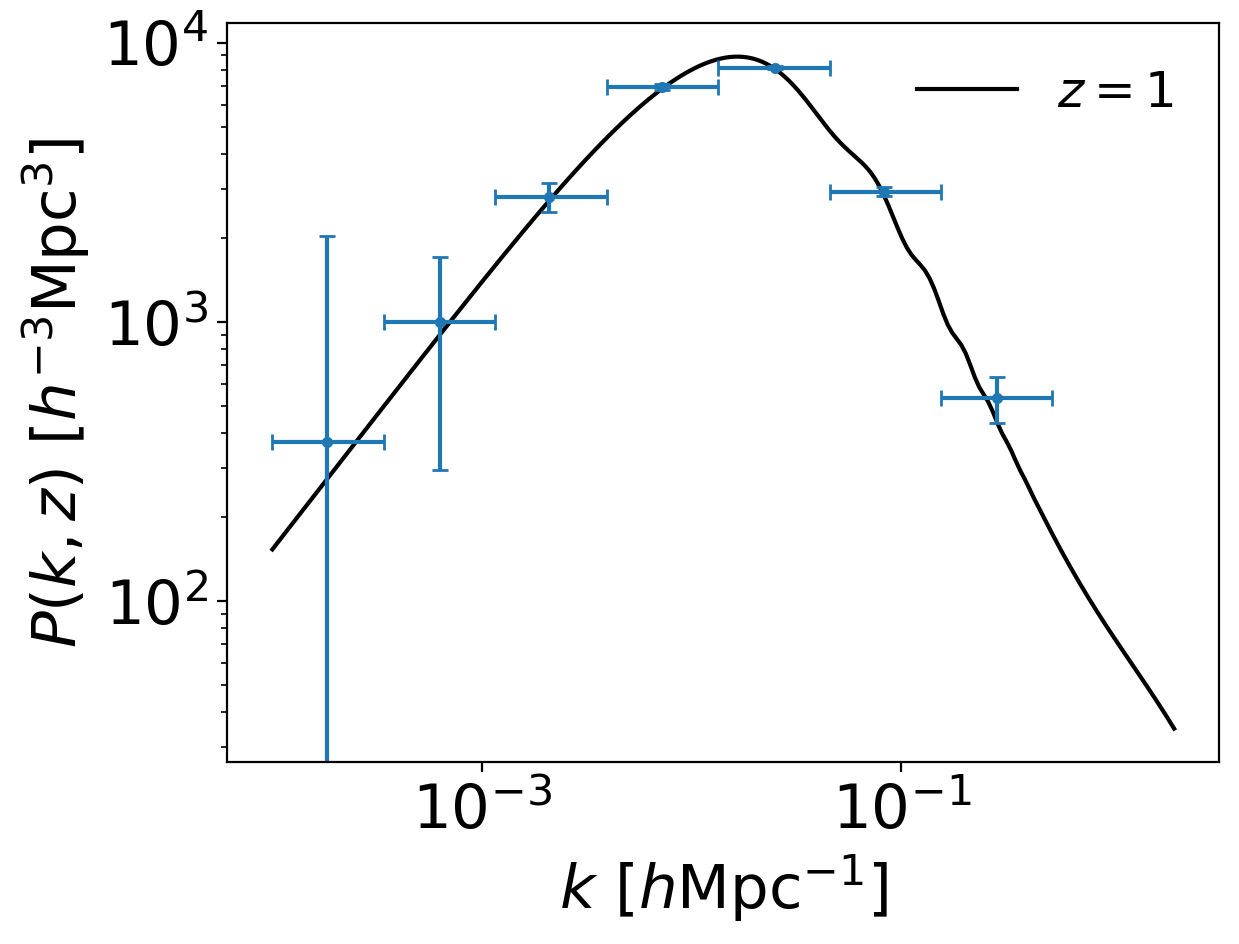

In [10]:
fig,ax=plt.subplots()
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    ax.loglog(kh, pk_nonlin[i,:], color='k', ls = line, label=r'$z=%d$'%redshift)
    errorbars = get_Pk_errorbars(kh, pk_nonlin[i,:], mink = 1e-4, maxk = 1, dk_k = 2.4, cosmoParams = pars, surveyParams = surveyParams)
    print(errorbars[:,3:].shape)
    ax.errorbar(errorbars[:,0], errorbars[:,1], yerr = errorbars[:,2], xerr = [errorbars[:,3],errorbars[:,4]],
                marker='.', ls='none', capsize=3)
ax.set_xlabel(r'$k\,\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k,z)\,\,[h^{-3}\mathrm{Mpc}^3]$')
ax.legend(frameon=False,fontsize=18)
plt.show()

## Measure $P(k)$ from a simulation